In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [15]:
pizza_df = pd.read_csv(r'C:\Users\jakob\Downloads\archive (2)\PJME_hourly.csv', delimiter= ',')
pizza_df
#"C:\Users\jakob\Downloads\archive (2)\PJME_hourly.csv"

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [32]:
ab_df = pd.read_csv('../../data/interim/absences_per_day.csv', sep=',')
#only keep columns index and count 
ab_df = ab_df[['index', 'count']]
#rename index to date
ab_df = ab_df.rename(columns={'index': 'date'})
ab_df['date'] = pd.to_datetime(ab_df['date'])

ab_df

,date,count
0,2020-01-02,2
1,2020-01-03,2
2,2020-01-04,2
3,2020-01-05,1
4,2020-01-06,1
...,...,...
1453,2023-12-25,60
1454,2023-12-26,60
1455,2023-12-27,213
1456,2023-12-28,211


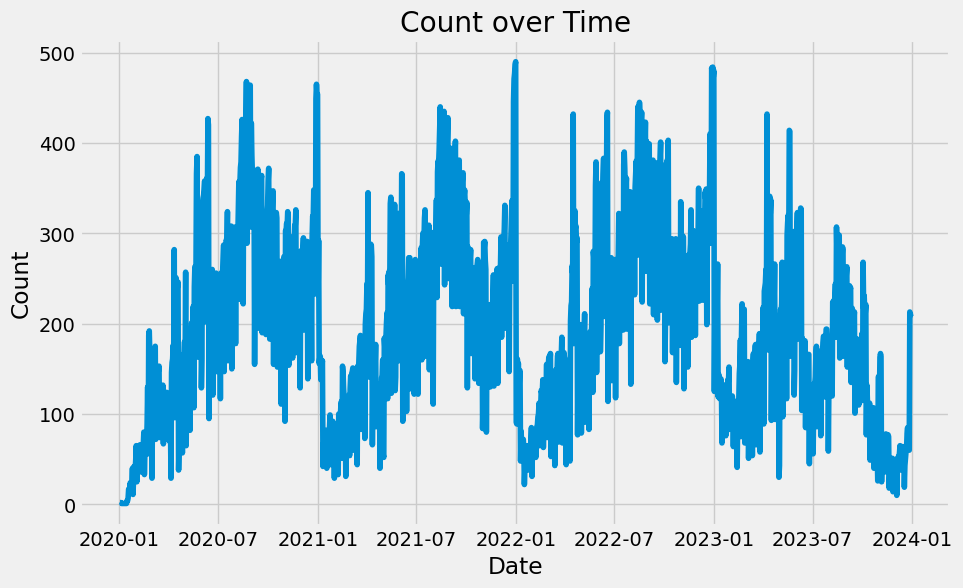

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(ab_df['date'], ab_df['count'], marker='o', linestyle='-', markersize=1)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time')
plt.grid(True)
plt.show()

In [34]:
split_date = '01-Jan-2022'
ab_train = ab_df.loc[ab_df['date'] <= split_date].copy()
ab_test = ab_df.loc[ab_df['date'] > split_date].copy()

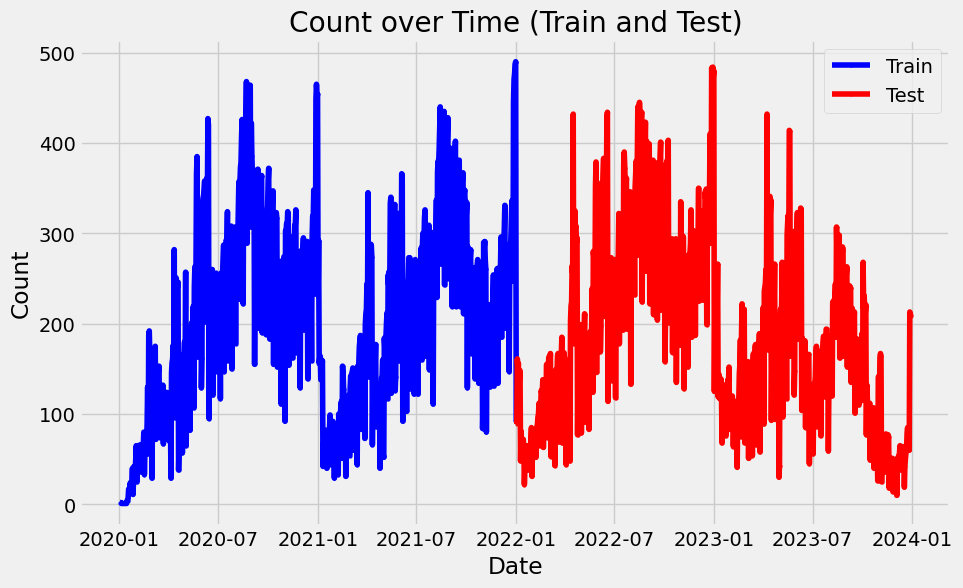

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(ab_train['date'], ab_train['count'], marker='o', linestyle='-', markersize=2, color='blue', label='Train')

# Plot the test set with another color (e.g., red)
plt.plot(ab_test['date'], ab_test['count'], marker='o', linestyle='-', markersize=2, color='red', label='Test')

plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Count over Time (Train and Test)')
plt.legend()  # Add legend to distinguish between Train and Test
plt.grid(True)
plt.show()

In [38]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df['date']
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [42]:
X_train, y_train = create_features(ab_train, label='count')
X_test, y_test = create_features(ab_test, label='count')

C:\Users\jakob\AppData\Local\Temp\ipykernel_20368\1007601217.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
C:\Users\jakob\AppData\Local\Temp\ipykernel_20368\1007601217.py:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [43]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

c:\Users\jakob\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

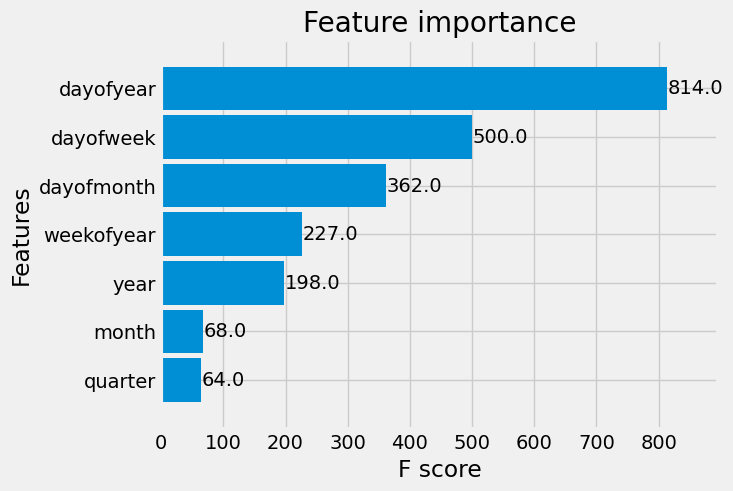

In [44]:
_ = plot_importance(reg, height=0.9)


In [45]:
ab_test['absence_Prediction'] = reg.predict(X_test)
count_all = pd.concat([ab_test, ab_train], sort=False)

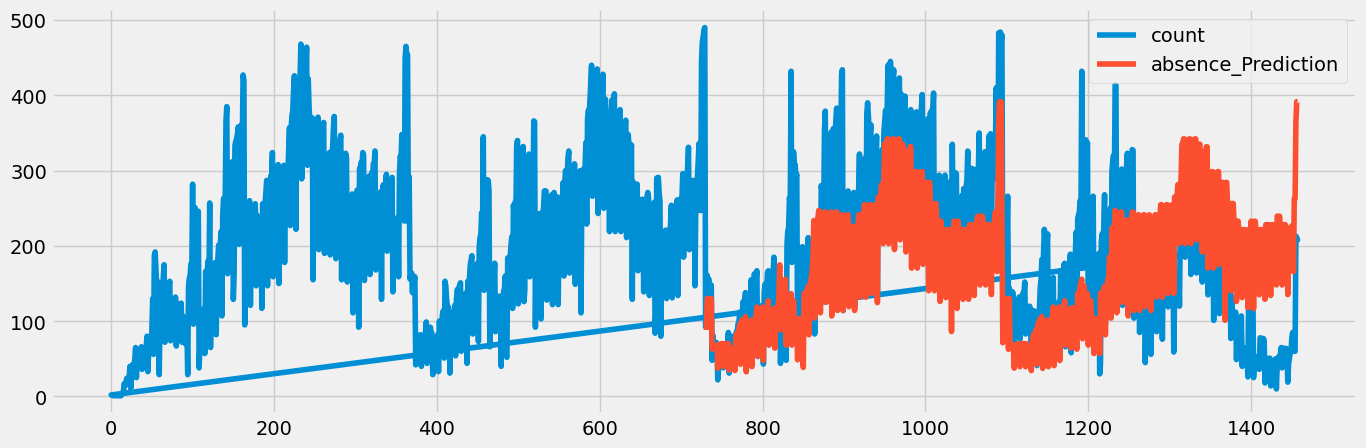

In [48]:
_ = count_all[['count','absence_Prediction']].plot(figsize=(15, 5))


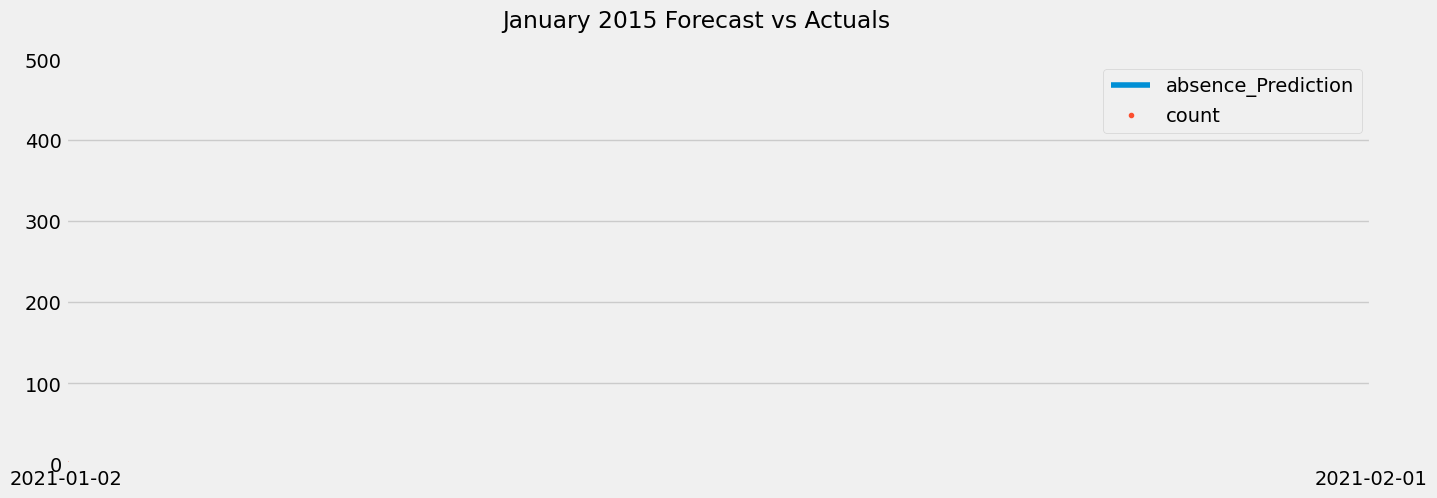

In [56]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = count_all[['absence_Prediction','count']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='2021-01-02', upper='2021-02-01')
ax.set_ylim(0, 500)
plot = plt.suptitle('January 2015 Forecast vs Actuals')